# <span style="color:#e0bda8; font-size: 40px;">To Grant or Not to Grant</span>


# <span style="color:#e0bda8">0. Context</span>

The New York Workers’ Compensation Board (WCB) handles claims related to workplace injuries, a process that is often time-consuming when done manually. This project aims to develop a machine learning model to predict the "Claim Injury Type" based on historical claims data from 2020 to 2022. By automating this classification, we can help the WCB make quicker and more accurate decisions.

The project involves building and evaluating various multiclass classification models, optimizing their performance, and exploring key features that contribute to accurate predictions. Ultimately, the goal is to identify the best model that can efficiently assist in the decision-making process for new claims.


# <span style="color:#e0bda8">1. Import Packages and Libraries</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import os
import sqlite3
from itertools import product
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

# <span style="color:#e0bda8">2. Reading the Data</span>

In [2]:
df = pd.read_csv('Data/train_data.csv')
df

<ipython-input-2-13981d7911e5>:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/train_data.csv')


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593466,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593467,2022-12-13,72.0,N,2022-12-31,N,0.00,1950.0,2022-12-31,NaN,TECHNOLOGY INSURANCE CO. INC.,...,25.0,FROM DIFFERENT LEVEL (ELEVATION),90.0,MULTIPLE PHYSICAL INJURIES ONLY,-9.0,MULTIPLE,12779,0.0,Not Work Related,3.0
593468,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593469,NaN,NaN,NaN,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# <span style="color:#e0bda8">3. Metadata</span>
- **Accident Date** - Injury date of the claim.
- **Age at Injury** - Age of injured worker when the injury occured.
- **Alternative Dispute Resolution** - Adjudication processes external to the Board.
- **Assembly Date** - The date the claim was first assembled.
- **Attorney/Representative** - Is the claim being represented by an Attorney?
- **Average Weekly Wage** - The wage used to calculate workers' compensation, disability, or an Paid Leave wage replacement benefits.
- **Birth Year** - The reported year of birth of the injured worker.
- **C-2 Date** - Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2).
- **C-3 Date** - Date Form C-3 (Employee Claim Form) was received.
- **Carrier Name** - Name of primary insurance provider responsible for providing workers' compensation coverage to the injured worker's employer.
- **Carrier Type** - Type of primary insurance provider responsible for providing workers' compensation coverage.
- **Claim Identifier** - Unique identifier for each claim, assigned by WCB.
- **Count of Injury** - Name of the New York County where the injury occured.
- **COVID-19 Indicator** - Indication that the claim may be associated with COVID-19.
- **District Name** - Name of the WCB district office that oversees claims for that region or area of the state.
- **First Hearing Date** - Date the first hearing was held on a claim at a WCB hearing location. A blank date means the claim has not yet had a hearing held.
- **Gender** - The reported gender of the injured worker.
- **IME-4 Count** - Number of IME-4 forms received per claim. The IME-4 form is the "Independent Examiner's Report of Independent Medical Examination" form.
- **Industry Code** - NAICS code and descriptions are available at: https://www.naics.com/search-naics-codes-by-industry/.
- **Industry Code Description** - 2-digit NAICS industry code description used to classify businesses according to their economic activity.
- **Medical Fee Region** - Approximate region where the injured worker would receive medical service.
- **OIICS Nature of Injury Description** - The OIICS nature of injury codes & descriptions are available at: https://www.bls.gov/iif/oiics_manual_2007.pdf.
- **WCIO Cause of Injury Code** - The WCIO cause of injury codes & descriptions are  at https://www.wcio.org/Active%20PNC/WCIO_Cause_Table.pdf.
- **WCIO Cause of Injury Description** - See description of field above.
- **WCIO Nature of Injury Code** - The WCIO nature of injury are available at
 https://www.wcio.org/Active%20PNC/WCIO_Nature_Table.pdf.
- **WCIO Nature of Injury Description** - See description of field above.
- **WCIO Part Of Body Code** - The WCIO part of body codes & descriptions are available at https://www.wcio.org/Active%20PNC/WCIO_Part_Table.pdf.
- **WCIO Part Of Body Description** - See description of field above.
- **Zip Code** - The reported ZIP code of the injured worker’s home address.
- **Agreement Reached** - Binary variable: Yes if there is an agreement without the involvement of the WCB -> unknown at the start of a claim.
- **WCB Decision** - Multiclass variable: Decision of the WCB relative to the claim: “Accident” means that claim refers to workplace accident, “Occupational Disease” means illness from the workplace. -> requires WCB deliberation so it is unknown at start of claim.
- **Claim Injury Type** - Main target variable: Deliberation of the WCB relative to benefits awarded to the claim. Numbering indicates severity.

# <span style="color:#e0bda8">4. Initial Analysis</span>

## What are some characteristics of our data?

In [3]:
df.shape

(593471, 33)

In [4]:
df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [6]:
df['OIICS Nature of Injury Description'].value_counts(dropna=False)

OIICS Nature of Injury Description
NaN    593471
Name: count, dtype: int64

## Initial Data Insights

After importing the dataset and using the `info()` method, we gathered the following key insights:

### 1. Missing Values:
   Almost all columns in the dataset have missing values, except for:
- `Assembly Date`
- `Claim Identifier`

The variable `OIICS Nature of Injury Description` contains no non-null values, indicating that it is entirely missing across all entries in the dataset.


### 2. Potential Data Type Issues:
   - **Date Columns** (`Accident Date`, `Assembly Date`, `C-2 Date`, `C-3 Date`, `First Hearing Date`): These are currently stored as `object` types. They should be converted to `datetime` format for easier manipulation and analysis.
   - **COVID-19 Indicator** and **Attorney/Representative**: These are likely binary variables but are stored as `object` types. Converting them to categorical or binary (`0` and `1`) might be more appropriate.
   - **`Agreement Reached`**: Currently stored as `float64`. If this column represents a binary outcome (e.g., Yes/No), it should be converted to an integer or categorical type.

These insights suggest that the dataset will require thorough preprocessing, including handling missing values and correcting data types to more suitable formats.

In [7]:
df.describe(include = 'all').round(2).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Accident Date,570337,5539,2020-03-01,1245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age at Injury,574026.0,NaN,NaN,NaN,42.11,14.26,0.0,31.0,42.0,54.0,117.0
Alternative Dispute Resolution,574026,3,N,571412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Assembly Date,593471,1096,2020-03-06,1422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attorney/Representative,574026,2,N,392291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Weekly Wage,545375.0,NaN,NaN,NaN,491.09,6092.92,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,NaN,NaN,NaN,1886.77,414.64,0.0,1965.0,1977.0,1989.0,2018.0
C-2 Date,559466,2475,2021-05-11,1847,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-3 Date,187245,1648,2021-04-21,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Carrier Name,574026,2046,STATE INSURANCE FUND,111144,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Claim Identifier analysis
df[df["Claim Identifier"].duplicated() == True].T

,526445
Accident Date,NaN
Age at Injury,NaN
Alternative Dispute Resolution,NaN
Assembly Date,2022-09-05
Attorney/Representative,NaN
Average Weekly Wage,NaN
Birth Year,NaN
C-2 Date,NaN
C-3 Date,NaN
Carrier Name,NaN


In [9]:
df[df["Claim Identifier"]==292668076]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
257901,NaN,NaN,NaN,2021-05-21,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526445,NaN,NaN,NaN,2022-09-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Observations and Irregularities in Dataset

### 1. Missing Values
- The **OIICS Nature of Injury Description** column has no entries at all (`0.0 count`), indicating that this variable is entirely missing. This may require dropping the column from analysis or substituting it with an appropriate placeholder if needed.

### 2. Extreme Values in Numerical Columns
- **Average Weekly Wage**: The maximum value is **2,828,079**, which seems unusually high compared to the mean of **491.09**. This may indicate outliers or data entry errors.
- **Claim Identifier**: The mean is very high at **23,667,598.79** with a maximum value of **999,891,667.0**, which could suggest an issue with how these identifiers are generated or logged. This high variability may require further examination.

### 3. Unusual Values for Categorical Variables
- **Gender**: There are **4 unique values** for this column, which is unexpected if it typically only represents male and female. Investigating these unique values could be helpful.
- **WCB Decision**: The count indicates that every entry states “Not Work Related,” suggesting that this variable may not be functioning as expected, or it might require further investigation into why other categories are absent.

### 4. Variability in Date Columns
- Both **Accident Date** and **Assembly Date** have high unique counts (5539 and 1096, respectively), indicating diverse dates, but the frequency of specific dates (like `2020-03-01` for Accident Date) could suggest clustering or common reporting patterns.
- **C-3 Date** has significantly fewer non-null entries (187,245), indicating that not all claims have received this form, which may impact analysis regarding claims processing times.

### 5. Binary Variables with Low Variability
- **Agreement Reached** has a mean of **0.05**, indicating that only about 5% of claims result in an agreement without the involvement of WCB. This could signal a lack of diversity in outcomes.
- **COVID-19 Indicator** has a similar pattern, showing that the majority of claims do not appear to be related to COVID-19, which could skew insights if this factor is essential for analysis.

### 6. High Cardinality in Categorical Variables
- **Carrier Name** and **County of Injury** have a large number of unique values (2046 and 63, respectively). While this is expected in datasets with various providers and geographical locations, it may complicate analysis and visualization, leading to potential overfitting in models if not handled properly.

### 7.Claim Identifier as a Potential Index
- **Claim Identifier** contains a unique identifier for each claim, assigned by WCB, sugesting that it could potentially serve as the Index of the DataFrame. There was only one duplicate value found, of ehich only two features did not contai NAs, further suporting this possibility. 

## Recommendations
- **Data Cleaning**: Consider dropping or filling in missing values for entirely missing columns. Outliers should be investigated to determine if they are legitimate data points or errors.
- **Examine Unique Values**: Review categorical columns with unexpected unique counts to understand their implications on your analysis.
- **Standardization**: Standardizing formats (e.g., for dates) and converting categorical variables into more manageable forms (e.g., one-hot encoding) may improve the analysis and modeling process.
- **Outlier Handling**: Use methods such as IQR or z-scores to identify and potentially treat outliers in numerical columns.

## Variance

In [10]:
df.var(numeric_only=True)

Age at Injury                         2.032459e+02
Average Weekly Wage                   3.712365e+07
Birth Year                            1.719300e+05
Claim Identifier                      1.164827e+16
IME-4 Count                           8.021942e+00
Industry Code                         3.858936e+02
OIICS Nature of Injury Description             NaN
WCIO Cause of Injury Code             6.694784e+02
WCIO Nature of Injury Code            4.931740e+02
WCIO Part Of Body Code                5.002353e+02
Agreement Reached                     4.448758e-02
Number of Dependents                  4.003206e+00
dtype: float64

## Insights from Variance Output of Numeric Variables

### 1. **High Variability in Key Variables**
- **Average Weekly Wage**: The variance of **37,123,650** suggests a significant disparity in wages among the claims. This indicates that while many claimants may earn a typical wage, there are outliers earning substantially higher amounts. This high variance could skew analyses related to compensation and benefits.
  
- **Claim Identifier**: With a variance of **1.164827e+16**, this suggests a large range of values. If this is truly an identifier, it should ideally have low variance, indicating a consistent format across entries. A high variance in claim identifiers may point to inconsistencies in data entry or generation processes.

### 2. **Moderate to Low Variability in Other Variables**
- **Age at Injury**: The variance of **203.25** indicates that most injured workers fall within a relatively similar age range, but with some variation. This could help identify demographic trends in workplace injuries.
  
- **IME-4 Count**: A variance of **8.02** suggests that the number of IME-4 forms received per claim does not vary widely, indicating that most claims are likely processed similarly in terms of medical evaluations.

- **Number of Dependents**: The variance of **4.00** shows some variability, suggesting that claims can vary in the number of dependents involved. This may affect benefit calculations and eligibility for support.

### 3. **Low Variance in Certain Injury Codes**
- **Industry Code**: The variance of **385.89** indicates diversity in industries but also suggests that many claims likely come from a core set of industries, which could be explored further in analysis.

- **WCIO Cause of Injury Code** and **WCIO Nature of Injury Code** have variances of **669.48** and **493.17**, respectively, suggesting a moderate amount of variability in the nature and causes of injuries, but still indicate some level of concentration in certain categories.

### 4. **Variable with No Variance**
- **OIICS Nature of Injury Description** has no entries (NaN), indicating a complete lack of data. This variable should either be addressed through data cleaning or removed from further analysis.

### 5. **Binary Variable Variance**
- **Agreement Reached** has a very low variance of **0.0445**, reflecting that the vast majority of claims do not result in an agreement without the involvement of WCB. This suggests that such outcomes are rare and may require special consideration in analyses.

## Recommendations
- **Investigate Outliers**: For variables with high variance, especially Average Weekly Wage, consider investigating outliers to determine if they represent legitimate data points or errors.
- **Data Validation**: Ensure that the Claim Identifier is being generated and recorded consistently across the dataset to prevent issues in further analyses.
- **Explore Demographics**: Utilize the Age at Injury variable to analyze trends related to age demographics in workplace injuries.
- **Consider Variable Removal**: If certain variables (like OIICS Nature of Injury Description) are consistently NaN, they may not be useful for analysis and should be considered for removal.



# <span style="color:#e0bda8">5. Data Preprocessing</span>

## Duplicates

In [11]:
df[df.duplicated()]

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents


In [12]:
df.duplicated().sum()

0

## Binary Representation Conversion

In [13]:
df['COVID-19 Indicator'].value_counts()

COVID-19 Indicator
N    546505
Y     27521
Name: count, dtype: int64

In [14]:
# Convert COVID-19 Indicator to binary representation
df['COVID-19 Indicator'] = df['COVID-19 Indicator'].map({'Y': 1, 'N': 0})

# Verify the conversion
df['COVID-19 Indicator'].value_counts()

COVID-19 Indicator
0.0    546505
1.0     27521
Name: count, dtype: int64

In [15]:
df['Attorney/Representative'].value_counts()

Attorney/Representative
N    392291
Y    181735
Name: count, dtype: int64

In [16]:
# Convert Attorney/Representative to binary representation
df['Attorney/Representative'] = df['Attorney/Representative'].map({'Y': 1, 'N': 0})

# Verify the conversion
df['Attorney/Representative'].value_counts()

Attorney/Representative
0.0    392291
1.0    181735
Name: count, dtype: int64

In [17]:
df['Alternative Dispute Resolution'].value_counts()

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

<span style="color: red;">Aqui mudei a categoria 'U' (Unknown) para missing value, não sei se é o melhor a fazer</span>

In [18]:
# Convert Attorney/Representative to binary representation
df['Alternative Dispute Resolution'] = df['Alternative Dispute Resolution'].map({'Y': 1, 'N': 0, 'U':np.nan})

# Verify the conversion
df['Alternative Dispute Resolution'].unique()

array([ 0., nan,  1.])

## Missing Values

In [19]:
# Check number of missing values
df.isna().sum()

Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19450
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region                     19445
OIICS Natu

In [20]:
# Check percentage of missing values
df.isna().sum() / df.shape[0] * 100

Accident Date                           3.898084
Age at Injury                           3.276487
Alternative Dispute Resolution          3.277329
Assembly Date                           0.000000
Attorney/Representative                 3.276487
Average Weekly Wage                     8.104187
Birth Year                              8.176137
C-2 Date                                5.729850
C-3 Date                               68.449174
Carrier Name                            3.276487
Carrier Type                            3.276487
Claim Identifier                        0.000000
Claim Injury Type                       3.276487
County of Injury                        3.276487
COVID-19 Indicator                      3.276487
District Name                           3.276487
First Hearing Date                     74.590502
Gender                                  3.276487
IME-4 Count                            77.622664
Industry Code                           4.954412
Industry Code Descri

## Outliers

## Categorical Variables

## Feature Engineering

## Data Scaling

# <span style="color:#e0bda8">6. Feature Selection</span>

In [21]:
# Define the independent variables as X and the dependent variable as y
X = df.drop('Claim Injury Type', axis = 1)
y = df['Claim Injury Type']

In [22]:
# Separate numeric and non-numeric columns
X_numeric = X.select_dtypes(include=[np.number])
X_non_numeric = X.select_dtypes(exclude=[np.number])

# Fill numeric columns with their mean (explorar se devemos substituir com a mediana!)
X_numeric_filled = X_numeric.fillna(X_numeric.mean())

# Fill non-numeric columns with the most frequent value (mode)
X_non_numeric_filled = X_non_numeric.apply(lambda col: col.fillna(col.mode()[0]))

# Combine them back
X_filled = pd.concat([X_numeric_filled, X_non_numeric_filled], axis=1)

# Drop the "OIICS Nature of Injury Description" column from X_filled
X_filled = X_filled.drop(columns=["OIICS Nature of Injury Description"], errors='ignore')

# Fill missing values in y with the mode
y_filled = y.fillna(y.mode()[0])

In [23]:
#Não será melhor substituir com a mediana, pelo menos em casos como Claim Identifier em que a diferença é muito acentuada? 
X_numeric.agg(["mean", "median"]).T

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\numpy\lib\nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,mean,median
Age at Injury,4.211427e+01,42.0
Alternative Dispute Resolution,4.545130e-03,0.0
Attorney/Representative,3.165972e-01,0.0
Average Weekly Wage,4.910883e+02,0.0
Birth Year,1.886768e+03,1977.0
Claim Identifier,2.366760e+07,5791212.0
COVID-19 Indicator,4.794382e-02,0.0
IME-4 Count,3.207337e+00,2.0
Industry Code,5.864531e+01,61.0
OIICS Nature of Injury Description,NaN,NaN


In [24]:
# Quando os MV tiverem corretamente preenchidos, fazer as devidas alterações no X, y e stratify
X_train, X_val, y_train, y_val = train_test_split(X_filled, y_filled, test_size=0.3,
                                                  random_state=0,
                                                  stratify=y_filled, 
                                                  shuffle=True)

In [25]:
# Divide in numerical and categorical features
X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_num.drop('Claim Identifier', axis = 1, inplace = True)

X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
X_train_cat['Claim Identifier'] = X_train['Claim Identifier']

# Repeat for Validation
X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)

X_val_num.drop('Claim Identifier', axis = 1, inplace = True)

X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)
X_val_cat['Claim Identifier'] = X_val['Claim Identifier']

In [26]:
X_train_num.columns

Index(['Age at Injury', 'Alternative Dispute Resolution',
       'Attorney/Representative', 'Average Weekly Wage', 'Birth Year',
       'COVID-19 Indicator', 'IME-4 Count', 'Industry Code',
       'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
       'WCIO Part Of Body Code', 'Agreement Reached', 'Number of Dependents'],
      dtype='object')

In [27]:
X_train_cat.columns

Index(['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date',
       'Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'First Hearing Date', 'Gender', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Description',
       'Zip Code', 'WCB Decision', 'Claim Identifier'],
      dtype='object')

In [28]:
#call function
scaler = MinMaxScaler()

#fit to training data
scaler.fit(X_train_num)

#transform the data
X_train_num_scaled = scaler.transform(X_train_num) # this will return an array

#show results
X_train_num_scaled

array([[0.35995103, 0.00454513, 0.31659716, ..., 0.45127913, 0.04666513,
        0.50109316],
       [0.47008547, 0.        , 0.        , ..., 0.47222222, 0.        ,
        0.16666667],
       [0.26495726, 0.        , 1.        , ..., 0.58333333, 0.        ,
        0.83333333],
       ...,
       [0.18803419, 0.        , 0.        , ..., 0.21296296, 0.        ,
        0.83333333],
       [0.18803419, 0.        , 0.        , ..., 0.57407407, 0.        ,
        0.16666667],
       [0.5042735 , 0.        , 1.        , ..., 0.91666667, 1.        ,
        0.16666667]])

In [29]:
# Convert the array to a pandas dataframe
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_scaled.head(5)

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,COVID-19 Indicator,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
476716,0.359951,0.004545,0.316597,0.000185,0.934969,0.047944,0.046965,0.588214,0.544706,0.444598,0.451279,0.046665,0.501093
419547,0.470085,0.000000,0.000000,0.000000,0.974232,0.000000,0.046965,0.382716,0.316327,0.400000,0.472222,0.000000,0.166667
266436,0.264957,0.000000,1.000000,0.000307,0.986125,0.000000,0.000000,0.629630,0.744898,0.566667,0.583333,0.000000,0.833333
438222,0.521368,0.000000,0.000000,0.000000,0.971259,0.000000,0.046965,0.617284,0.265306,0.100000,0.574074,0.000000,1.000000
60875,0.264957,0.000000,0.000000,0.000000,0.985134,0.000000,0.046965,1.000000,0.306122,0.566667,0.574074,0.000000,1.000000


In [30]:
X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
X_val_num_scaled.head(5)

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,COVID-19 Indicator,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
161939,0.487179,0.0,0.0,0.000000,0.972745,0.0,0.046965,0.246914,0.581633,0.644444,0.435185,0.0,0.000000
443176,0.341880,0.0,0.0,0.000000,0.982161,0.0,0.046965,0.864198,0.602041,0.100000,0.388889,0.0,0.000000
228082,0.598291,0.0,1.0,0.000292,0.965808,1.0,0.042553,0.629630,0.836735,0.644444,0.916667,0.0,0.833333
141492,0.495726,0.0,1.0,0.000287,0.972250,0.0,0.000000,0.456790,0.602041,0.300000,0.398148,0.0,0.500000
149988,0.435897,0.0,0.0,0.000461,0.975719,0.0,0.046965,0.555556,0.244898,0.300000,0.379630,0.0,1.000000


## Filter Methods

### Basic Filter Methods

**Redundancy**: Temos Accident Date, Age at Injury e Birth Year, devemos tirar algum?

### Univariate Methods

In [31]:
X_train_num_scaled.var()

Age at Injury                     0.014370
Alternative Dispute Resolution    0.004335
Attorney/Representative           0.209179
Average Weekly Wage               0.000004
Birth Year                        0.038848
COVID-19 Indicator                0.044277
IME-4 Count                       0.000815
Industry Code                     0.056039
WCIO Cause of Injury Code         0.065731
WCIO Nature of Injury Code        0.057210
WCIO Part Of Body Code            0.040262
Agreement Reached                 0.042932
Number of Dependents              0.107644
dtype: float64

### Correlation Indices

Since we have a categorical target, measuring correlations against is ill-advised (we could however use other correlation indices for this such as Point Bi-serial correlation or PhiK). Thus we will limit ourselves to using the Spearman correlation between features.

In [32]:
# CODE HERE
cor_spearman = X_train_num_scaled.corr(method ='spearman').round(2)

mask_annot = np.absolute(cor_spearman.values) >= 0.5
annot = np.where(mask_annot, cor_spearman.values, np.full(cor_spearman.shape,"")) 
annot = annot.astype(str)  # Convert to string for annotation
mask = np.triu(np.ones_like(cor_spearman, dtype=bool))

# Define the custom colors
light_color = '#e0bda8'  # Light shade
dark_color = '#c48c78'   # Darker shade
neutral_color = '#ffffff' # Color for neutral values

# Create a custom colormap with three colors (for diverging effect)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dark_color, neutral_color, light_color])

cor_spearman

,Age at Injury,Alternative Dispute Resolution,Attorney/Representative,Average Weekly Wage,Birth Year,COVID-19 Indicator,IME-4 Count,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
Age at Injury,1.00,0.01,0.12,0.13,-0.75,0.01,-0.01,0.01,-0.02,0.04,0.02,0.02,0.00
Alternative Dispute Resolution,0.01,1.00,0.12,0.08,-0.25,0.55,0.04,-0.03,-0.06,-0.05,0.01,0.56,0.04
Attorney/Representative,0.12,0.12,1.00,0.53,-0.15,0.05,-0.17,0.01,0.01,0.05,-0.03,0.31,0.00
Average Weekly Wage,0.13,0.08,0.53,1.00,-0.10,0.03,-0.18,0.04,-0.01,0.04,0.01,0.14,0.00
Birth Year,-0.75,-0.25,-0.15,-0.10,1.00,-0.16,-0.00,0.01,0.02,-0.03,-0.03,-0.20,-0.01
COVID-19 Indicator,0.01,0.55,0.05,0.03,-0.16,1.00,0.05,0.07,0.18,0.24,0.25,0.34,0.03
IME-4 Count,-0.01,0.04,-0.17,-0.18,-0.00,0.05,1.00,-0.09,-0.02,0.00,0.03,0.01,-0.00
Industry Code,0.01,-0.03,0.01,0.04,0.01,0.07,-0.09,1.00,0.05,0.01,-0.03,-0.07,-0.00
WCIO Cause of Injury Code,-0.02,-0.06,0.01,-0.01,0.02,0.18,-0.02,0.05,1.00,0.19,0.04,-0.04,-0.00
WCIO Nature of Injury Code,0.04,-0.05,0.05,0.04,-0.03,0.24,0.00,0.01,0.19,1.00,0.22,0.00,-0.00


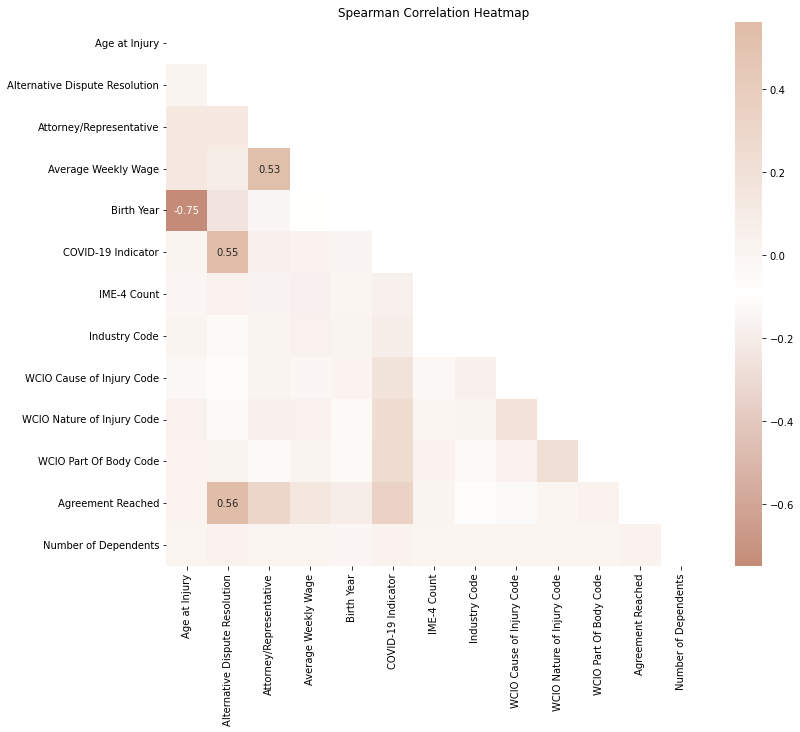

In [33]:
# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data=cor_spearman, annot=annot, cmap=custom_cmap, mask=mask, fmt='s')  # fmt='s' for string
plt.title('Spearman Correlation Heatmap')
plt.show()

We can conclude that:
- We need to use other feature selection techniques to get more insights.
- There are two pairs of variables highly correlated, namely:
    - Average Weekly Wage vs Attorney/Representative (0.53) <br>
    - Birth Year vs Age at Injury (-0.75) <br>
    - Alternative Dispute Resolution vs Agreement Reached (0.56)
    - Alternative Dispute Resolution vs COVID-19 Indicator (0.55)

We need to use other techniques of feature selection to decide which variables should we keep (another possible approach was to remove the Family_Size since it is correlated with both variables, but maybe this can have a higher influence on the target).

### Chi-Square for categorical data

In [34]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p>=alpha:
        result = "{0} is NOT an important predictor. (Discard {0} from model)".format(var)
        print(result)

In [35]:
for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

WCB Decision is NOT an important predictor. (Discard WCB Decision from model)
Claim Identifier is NOT an important predictor. (Discard Claim Identifier from model)


According to chi-square, we should discard `WCB Decision` and `Claim Identifier`.

### Visualize the weight of the dependent variable in categorical data (EXTRA)

In [36]:
# first join all the training data
all_train = X_train.join(y_train)

def bar_charts_categorical_multi(df, feature, target):
    # Create a contingency table without margins
    cont_tab = pd.crosstab(df[feature], df[target])
    categories = cont_tab.index

    # Set up the figure
    fig = plt.figure(figsize=(15, 6))
    
    # Define colors for each unique value in target variable
    target_categories = cont_tab.columns
    colors = sns.color_palette("husl", len(target_categories))  # Generate distinct colors

    # Frequency Bar Chart
    plt.subplot(121)
    cont_tab.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors, edgecolor='black')
    
    plt.title("Frequency Bar Chart")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.legend(title=target, bbox_to_anchor=(1, 1), loc='upper left')
    
    # Adding value annotations to the frequency bars
    for i in range(len(categories)):
        for j in range(len(cont_tab.columns)):
            if cont_tab.iloc[i, j] > 0:  # Avoid text on zero values
                plt.text(i, cont_tab.iloc[i, :].cumsum().iloc[j] - cont_tab.iloc[i, j] / 2, 
                         cont_tab.iloc[i, j], 
                         ha='center', va='center', color='white')

    # Proportion Bar Chart
    plt.subplot(122)
    
    # Calculate proportions
    obs_pct = cont_tab.div(cont_tab.sum(axis=1), axis=0)  # Proportion for each row
    
    # Plotting proportions with all bars having the same height (1)
    obs_pct.plot(kind='bar', stacked=True, ax=plt.gca(), color=colors, edgecolor='black')
    
    plt.title("Proportion Bar Chart")
    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title=target, bbox_to_anchor=(1, 1), loc='upper left')
    
    # Adding value annotations to the proportion bars
    for i in range(len(categories)):
        for j in range(len(obs_pct.columns)):
            if obs_pct.iloc[i, j] > 0:  # Avoid text on zero values
                plt.text(i, obs_pct.iloc[i, :].cumsum().iloc[j] - obs_pct.iloc[i, j] / 2, 
                         f"{obs_pct.iloc[i, j]:.2f}", 
                         ha='center', va='center', color='black')

    plt.tight_layout()
    plt.show()

In [37]:
X_train_cat.columns

Index(['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date',
       'Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'First Hearing Date', 'Gender', 'Industry Code Description',
       'Medical Fee Region', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Description',
       'Zip Code', 'WCB Decision', 'Claim Identifier'],
      dtype='object')

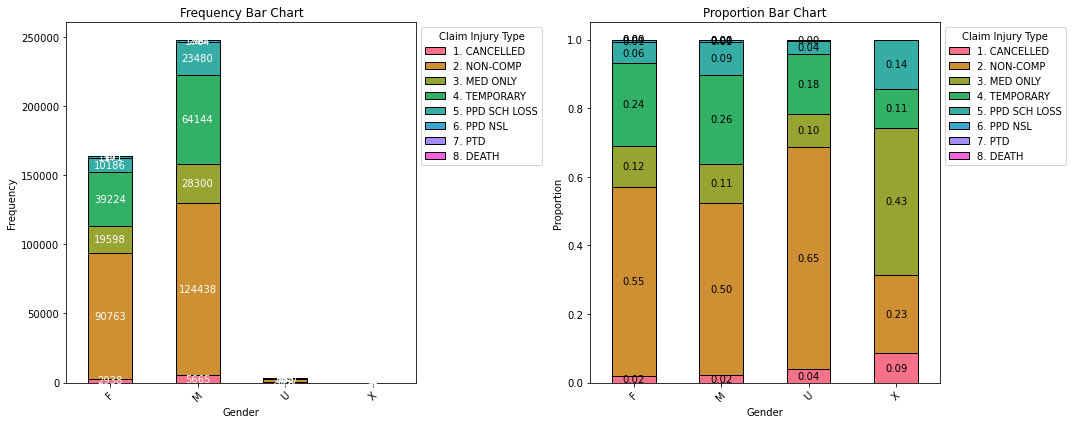

In [38]:
bar_charts_categorical_multi(all_train, "Gender", "Claim Injury Type")

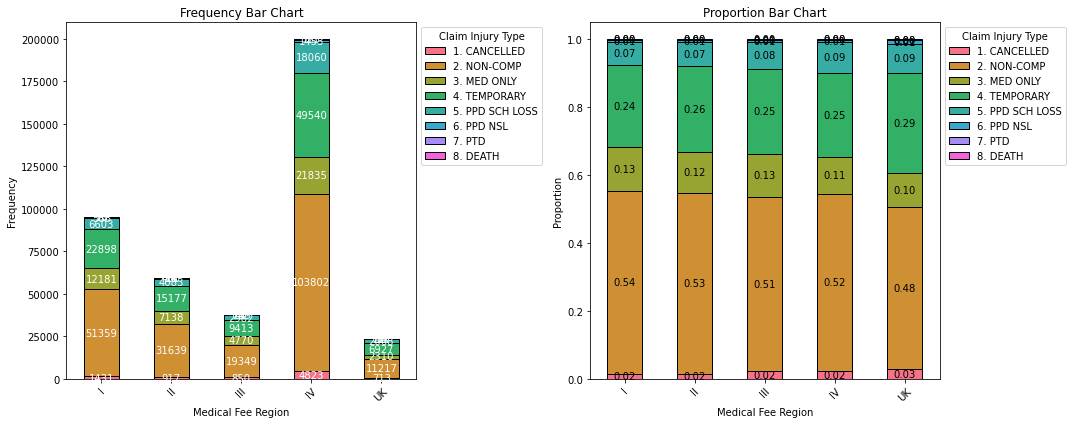

In [39]:
bar_charts_categorical_multi(all_train, "Medical Fee Region", "Claim Injury Type")

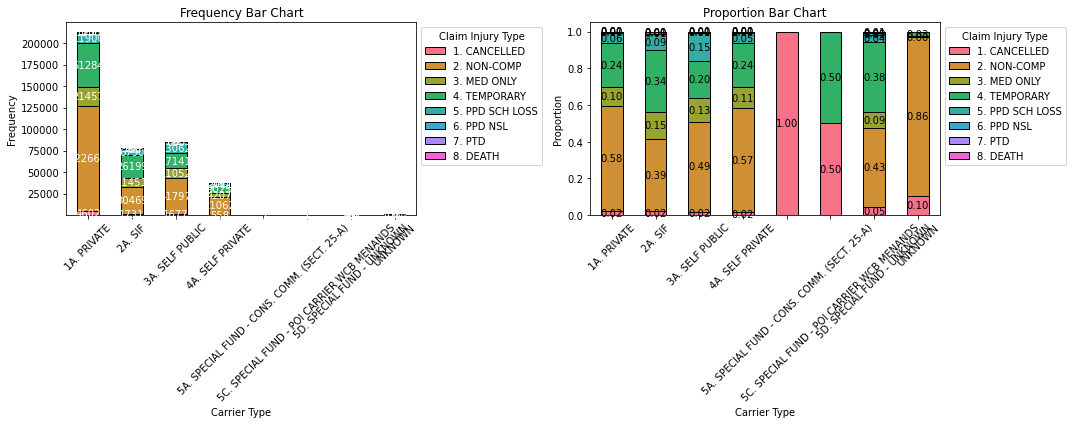

In [40]:
bar_charts_categorical_multi(all_train, "Carrier Type", "Claim Injury Type")

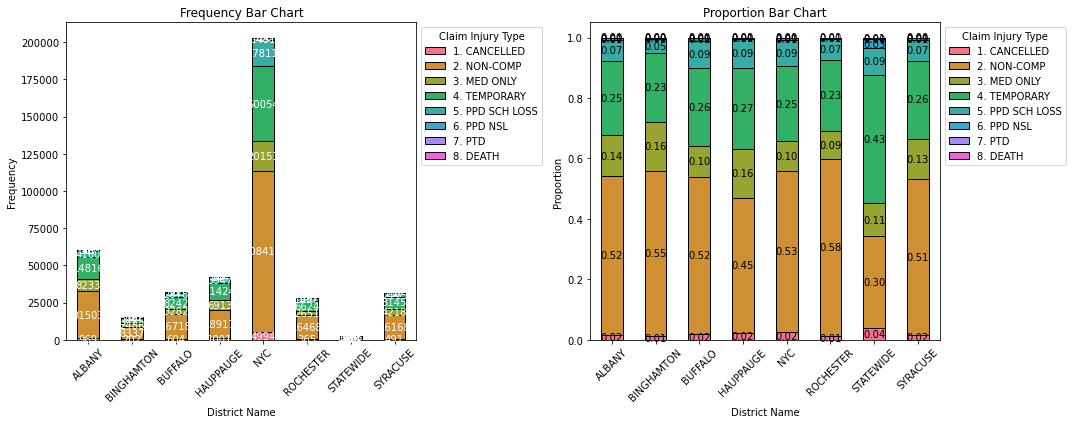

In [41]:
bar_charts_categorical_multi(all_train, "District Name", "Claim Injury Type")

## Wrapper Methods

### RFE (Logistic Regression)

If you don't know apriori the number of features to select you can create a loop to check the score of the estimator using a different number of features. <br>
Below you have an example that will check the score of the estimator by chosing between 1 and 7 variables. 
<span style="color: red;">Porque é que ele na aula fez de 1 a 7?</span>

In [31]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Optimum number of features: 10
Score with 10 features: 0.650274
Features to select: 
Age at Injury                      True
Alternative Dispute Resolution     True
Attorney/Representative            True
Average Weekly Wage               False
Birth Year                         True
COVID-19 Indicator                 True
IME-4 Count                        True
Industry Code                      True
WCIO Cause of Injury Code         False
WCIO Nature of Injury Code         True
WCIO Part Of Body Code             True
Agreement Reached                  True
Number of Dependents              False
dtype: bool


### RFE (Support Vector Classifier)

In [ ]:
#no of features
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = SVC(kernel = 'linear')
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_val_rfe,y_val)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
        
        #adding mention of variables to keep
        features_to_select = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

In [ ]:
#model = SVC(kernel = 'linear') 
#rfe = RFE(estimator = model, n_features_to_select = nof)
#X_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)
#selected_features1 = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
#selected_features1

### RFECV (RFE with cross validation) with Logistic Regression

In [32]:
model = LogisticRegression()

# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=10)  # 10-fold cross-validation

# Create the RFECV object
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the RFECV model to the training data
X_rfe = rfecv.fit_transform(X_train_num_scaled, y_train)

# Print the number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)

# Print the selected features
print("Selected features: %s" % rfecv.support_)

selected_features = pd.Series(rfecv.support_, index = X_train_num_scaled.columns)

selected_features

C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Optimal number of features: 12
Selected features: [ True  True  True  True  True  True  True  True  True  True  True  True
 False]


C:\Users\35191\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Age at Injury                      True
Alternative Dispute Resolution     True
Attorney/Representative            True
Average Weekly Wage                True
Birth Year                         True
COVID-19 Indicator                 True
IME-4 Count                        True
Industry Code                      True
WCIO Cause of Injury Code          True
WCIO Nature of Injury Code         True
WCIO Part Of Body Code             True
Agreement Reached                  True
Number of Dependents              False
dtype: bool

In [54]:
#selected_features = pd.Series(rfecv.support_, index = X_train_num_scaled.columns)
#selected_features

Age at Injury                      True
Alternative Dispute Resolution     True
Attorney/Representative            True
Average Weekly Wage                True
Birth Year                         True
COVID-19 Indicator                 True
IME-4 Count                        True
Industry Code                      True
WCIO Cause of Injury Code          True
WCIO Nature of Injury Code         True
WCIO Part Of Body Code             True
Agreement Reached                  True
Number of Dependents              False
dtype: bool

### RFECV (RFE with cross validation) with Support Vector Classifier

In [ ]:
model = SVC(kernel = 'linear')

# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=10)  # 10-fold cross-validation

# Create the RFECV object
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy', n_jobs=-1)

# Fit the RFECV model to the training data
X_rfe = rfecv.fit_transform(X_train_num_scaled, y_train)

# Print the number of features selected
print("Optimal number of features: %d" % rfecv.n_features_)

# Print the selected features
print("Selected features: %s" % rfecv.support_)

selected_features = pd.Series(rfecv.support_, index = X_train_num_scaled.columns)

selected_features

## Embedded Methods

### Lasso Regression

In [44]:
#Encoding y values

# Assuming y_train and y_val are your target labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)  # Fit and transform on training data

In [52]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh", color="#e0bda8")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [53]:
reg = LassoCV()

In [54]:
reg.fit(X_train_num_scaled, y_train_encoded)

LassoCV()

In [55]:
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
coef

Age at Injury                     0.596647
Alternative Dispute Resolution   -0.591987
Attorney/Representative           1.341673
Average Weekly Wage               0.000000
Birth Year                        0.134214
COVID-19 Indicator               -0.254459
IME-4 Count                      -0.695866
Industry Code                     0.146820
WCIO Cause of Injury Code        -0.138747
WCIO Nature of Injury Code        0.004879
WCIO Part Of Body Code            0.134417
Agreement Reached                 0.356455
Number of Dependents              0.002138
dtype: float64

In [56]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 12 variables and eliminated the other 1 variables


In [57]:
coef.sort_values()

IME-4 Count                      -0.695866
Alternative Dispute Resolution   -0.591987
COVID-19 Indicator               -0.254459
WCIO Cause of Injury Code        -0.138747
Average Weekly Wage               0.000000
Number of Dependents              0.002138
WCIO Nature of Injury Code        0.004879
Birth Year                        0.134214
WCIO Part Of Body Code            0.134417
Industry Code                     0.146820
Agreement Reached                 0.356455
Age at Injury                     0.596647
Attorney/Representative           1.341673
dtype: float64

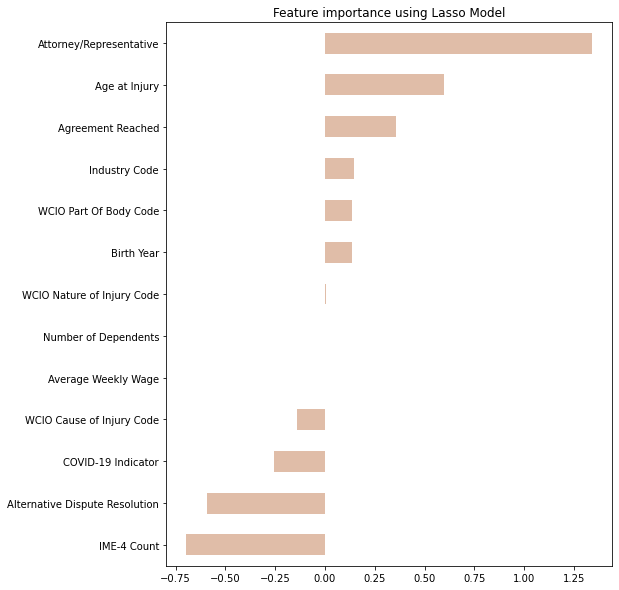

In [58]:
plot_importance(coef,'Lasso')

## Final Insights

<hr>

### Numerical Data

| Predictor | Spearman | RFE LR | RFE SVM | RFECV LR | RFECV SVM | Lasso | What to do? (One possible way to "solve") |
| --- | --- | --- | --- |--- |---|---|---|
| Age at Injury | - | - | - | - | - | - | - |
| Alternative Dispute Resolution | - | - | - | - | - | - | - |
| Attorney/Representative | - | - | - | - | - | - | - |
| Average Weekly Wage | - | - | - | - | - | - | - |
| Birth Year | - | - | - | - | - | - | - |
| COVID-19 Indicator | - | - | - | - | - | - | - |
| IME-4 Count | - | - | - | - | - | - | - |
| Industry Code | - | - | - | - | - | - | - |
| WCIO Cause of Injury Code | - | - | - | - | - | - | - |
| WCIO Nature of Injury Code | - | - | - | - | - | - | - |
| WCIO Part Of Body Code | - | - | - | - | - | - | - |
| Agreement Reached | - | - | - | - | - | - | - |
| Number of Dependents | - | - | - | - | - | - | - |

<hr>
<span style="color: red;">Inserir Keep / Discard / Keep? / Include in the model / Try with and without de acordo com o output do Spearman, RFE LG, RFE SVM, RFECV LG, RFECV SVM, Lasso</span>

### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| Accident Date | - |  
| Assembly Date | - | 
| C-2 Date | - |
| C-3 Date | - |
| Carrier Name | - | 
| Carrier Type | - | 
| County of Injury | - |
| District Name | - | 
| First Hearing Date | - |  
| Gender | - | 
| Industry Code Description | - |
| Medical Fee Region | - |
| WCIO Cause of Injury Description | - | 
| WCIO Nature of Injury Description | - | 
| WCIO Part Of Body Description | - |
| Zip Code | - | 
| WCB Decision | - |  
| Claim Identifier | - | 

<hr>
<span style="color: red;">Inserir Keep ou Discard de acordo com o output da Chi-Square</span>

# <span style="color:#e0bda8">7. Modelling and Assessment</span>